# ACILIMDB Emotion Analysis

Using the ACILIMDB dataset, we will train a model to predict the emotion of a given text. The dataset contains 25,000 labeled samples for training and 25,000 labeled samples for testing. The labels are binary, with 1 indicating a positive emotion and 0 indicating a negative emotion.

This notebook will walk through the following steps:
1. Load the dataset
2. Preprocess the text data
3. Define RNN and LSTM models
4. Train the models
5. Compare the models

Let's get started!

## Dataset

In [22]:
import collections
import os
import random
import torch
from torch import nn
import torch.utils.data as Data


DATA_ROOT = "./data/aclImdb"

In [23]:
from tqdm import tqdm


def read_imdb(folder="train", data_root=None) -> list:
    data = []
    for label in ["pos", "neg"]:
        folder_name = os.path.join(data_root, folder, label)
        for file in tqdm(os.listdir(folder_name)):
            with open(os.path.join(folder_name, file), "rb") as f:
                review = f.read().decode("utf-8").replace("\n", "").lower()
                data.append([review, 1 if label == "pos" else 0])
    random.shuffle(data)
    return data


train_data, test_data = read_imdb("train", DATA_ROOT), read_imdb("test", DATA_ROOT)

  0%|          | 0/12500 [00:00<?, ?it/s]

100%|██████████| 12500/12500 [00:00<00:00, 28744.43it/s]


2470


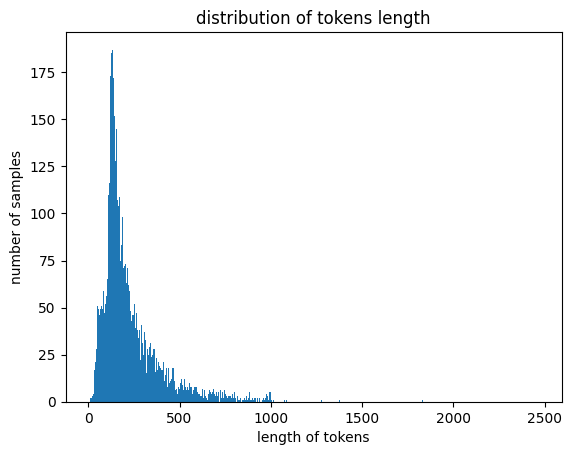

In [24]:
# draw the distribution of tokens length
import matplotlib.pyplot as plt

train_tokens = [line.split() for line, _ in train_data]
num_tokens = [len(tokens) for tokens in train_tokens]
max_len = max(num_tokens)
print(max_len)

plt.hist(num_tokens, bins=range(max_len))
plt.xlabel("length of tokens")
plt.ylabel("number of samples")
plt.title("distribution of tokens length")
plt.show()

we need to tokenize each review into a list of words. Here, we use a simple method to split the text by space.

In [25]:
def get_tokenized_imdb(data) -> list:
    def tokenizer(text):
        tokens = [tok.lower() for tok in text.split()]
        return tokens

    return [tokenizer(review) for review, _ in data]

Now, we can create a vocabulary based on the tokenized training dataset. 

We filter out words that appear less than 5 times. 

The key of the vocabulary is the word, and the value is the index (starting from 2).

In [26]:
def get_vocab_imdb(data) -> dict:
    tokenized_data = get_tokenized_imdb(data)
    counter = collections.Counter([tk for st in tokenized_data for tk in st])

    sorted_by_freq = counter.most_common()

    # build a dictionary, key is the word, value is the index
    word_to_idx = {
        word: i + 2 for i, (word, freq) in enumerate(sorted_by_freq) if freq >= 5
    }

    # unknown token
    word_to_idx["<unk>"] = 1

    # padding token
    word_to_idx["<pad>"] = 0

    return word_to_idx


vocab = get_vocab_imdb(train_data)

print("vocab size:", len(vocab))

vocab size: 46159


Because the length of each review is different, we cannot directly combine them into batches. 

We define the preprocess_imdb function to tokenize each review, convert it to word indexes through the dictionary, and then truncate or pad 0 to fix the length of each review to 300.

> [!NOTE]
>
> if the you set the `max_words` to a larger value, if may cause Gradient Explosion and Gradient Vanishing.

In [27]:
def preprocess_imdb(data, vocab):
    max_l = 300

    def pad(x):
        return x[:max_l] if len(x) > max_l else x + [0] * (max_l - len(x))

    tokenized_data = get_tokenized_imdb(data)
    features = [[vocab.get(word, 1) for word in review] for review in tokenized_data]
    features = torch.tensor([pad(feature) for feature in features])

    labels = torch.tensor([score for _, score in data])
    return features, labels


Create a data iterator to read the dataset.

In [28]:
batch_size = 512
train_set = Data.TensorDataset(*preprocess_imdb(train_data, vocab))
test_set = Data.TensorDataset(*preprocess_imdb(test_data, vocab))
train_iter = Data.DataLoader(train_set, batch_size, shuffle=True)
test_iter = Data.DataLoader(test_set, batch_size)

Print the shape of the first batch of data and the number of batches in the training set.

In [29]:
for X, y in train_iter:
    print("X", X.shape, "y", y.shape)
    break
"#batches:", len(train_iter)

X torch.Size([512, 300]) y torch.Size([512])


('#batches:', 49)

## Model

### Pretrained Word Vectors

In [30]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thanakomsn/glove6b300dtxt")

print("Path to dataset files:", path)

Path to dataset files: /home/kaiwen/.cache/kagglehub/datasets/thanakomsn/glove6b300dtxt/versions/1


In [31]:
path = os.path.join(path, "glove.6B.300d.txt")

In [32]:
def load_glove_embeddings(glove_file_path, embedding_dim, vocab):
    """
    load glove embeddings

    param glove_file_path: str, path to glove file
    param embedding_dim: int, dimension of embeddings
    param vocab: dict, word -> index
    """
    embeddings_index = {}  # dict, word -> vector
    with open(glove_file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = torch.tensor([float(val) for val in values[1:]], dtype=torch.float)
            embeddings_index[word] = vector

    # initialize randomly
    vocab_size = len(vocab)
    embeddings_matrix = torch.randn(
        vocab_size, embedding_dim
    )  # tensor, vocab_size x embedding_dim

    for word, idx in vocab.items():
        if word in embeddings_index:
            embeddings_matrix[idx] = embeddings_index[word]
        else:
            embeddings_matrix[idx] = torch.randn(
                embedding_dim
            )  # if word not in embeddings_index, initialize randomly

    # set <PAD> and <UNK> embeddings to 0
    embeddings_matrix[0] = torch.zeros(embedding_dim)  # <PAD>
    embeddings_matrix[1] = torch.zeros(embedding_dim)  # <UNK>

    return embeddings_matrix


### RNN

In [33]:
class RNNModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim=100,
        hidden_size=128,
        pretrained_embedding=None,
    ):
        super(RNNModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        if pretrained_embedding is not None:
            self.embedding.weight.data.copy_(pretrained_embedding)

            # set `requires_grad` to False to avoid updating the pretrained embeddings
            self.embedding.weight.requires_grad = False

        self.rnn_layer = nn.RNN(
            embedding_dim,
            hidden_size,
            batch_first=True,
        )

        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        self.fc_layer = nn.Linear(hidden_size, 2)

    def forward(self, inputs, state):
        embedded = self.embedding(inputs)

        Y, state = self.rnn_layer(embedded, state)

        # Shape of Y: (`batch_size`, `num_steps`, `hidden_size`)

        output = self.fc_layer(Y[:, -1, :])
        return output, state

### LSTM

In [34]:
class LSTMModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim=300,
        num_hiddens=256,
        pretrained_embedding=None,
    ):
        super(LSTMModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        if pretrained_embedding is not None:
            self.embedding.weight.data.copy_(pretrained_embedding)

            # 设置不进行更新
            self.embedding.weight.requires_grad = False

        self.lstm_layer = nn.LSTM(
            embedding_dim,
            num_hiddens,
            batch_first=True,
        )

        self.hidden_size = num_hiddens
        self.vocab_size = vocab_size

        self.fc_layer = nn.Linear(num_hiddens, 2)

    def forward(self, inputs, state):
        embedded = self.embedding(inputs)

        Y, state = self.lstm_layer(embedded, state)

        # Y 的形状是 (batch_size, num_steps, num_hiddens)

        # 只取最后一个时间步的输出
        output = self.fc_layer(Y[:, -1, :])
        return output, state

## Train

### RNN

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [36]:
import torch.optim as optim


num_epochs = 30
learning_rate = 0.0001

vocab_size = len(vocab)
embedding_dim = 300
hidden_size = 256

pretrained_embedding = load_glove_embeddings(path, embedding_dim, vocab)

rnn_net = RNNModel(vocab_size, embedding_dim, hidden_size, pretrained_embedding).to(
    device
)

criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(rnn_net.parameters(), lr=learning_rate)


# train and evaluate
def train_rnn_model(model, train_iter, criterion, optimizer, device):
    model.train()  # 设置为训练模式
    total_loss, total_acc, num_batches = 0.0, 0.0, len(train_iter)

    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()  # 清除上一次的梯度
        state = None  # 隐藏状态清零
        output, _ = model(X, state)  # 正向传播
        loss = criterion(output, y)
        loss.backward()  # 反向传播

        # 梯度裁剪
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()  # 更新模型参数

        total_loss += loss.item()
        total_acc += (output.argmax(dim=1) == y).sum().item()

    avg_loss = total_loss / num_batches
    avg_acc = total_acc / len(train_iter.dataset)
    return avg_loss, avg_acc


def evaluate_rnn_model(model, test_iter, criterion, device):
    model.eval()
    total_loss, total_acc, num_batches = 0.0, 0.0, len(test_iter)

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(device), y.to(device)
            state = None
            output, _ = model(X, state)
            loss = criterion(output, y)

            total_loss += loss.item()
            total_acc += (output.argmax(dim=1) == y).sum().item()

    avg_loss = total_loss / num_batches
    avg_acc = total_acc / len(test_iter.dataset)
    return avg_loss, avg_acc


from torch.utils.tensorboard import SummaryWriter


def train_and_eval(
    model, train_iter, test_iter, criterion, optimizer, device, num_epochs, model_name
):
    writer = SummaryWriter(log_dir=f"logs/{model_name}")

    for epoch in range(num_epochs):
        train_loss, train_acc = train_rnn_model(
            model, train_iter, criterion, optimizer, device
        )
        test_loss, test_acc = evaluate_rnn_model(model, test_iter, criterion, device)

        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"  Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}")
        print(f"  Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("Loss/test", test_loss, epoch)
        writer.add_scalar("Accuracy/train", train_acc, epoch)
        writer.add_scalar("Accuracy/test", test_acc, epoch)


train_and_eval(
    rnn_net, train_iter, test_iter, criterion, optimizer, device, num_epochs, "rnn"
)

Epoch 1/30
  Train loss: 0.6940, Train accuracy: 0.5010
  Test loss: 0.6934, Test accuracy: 0.5045
Epoch 2/30
  Train loss: 0.6910, Train accuracy: 0.5192
  Test loss: 0.6932, Test accuracy: 0.5073
Epoch 3/30
  Train loss: 0.6884, Train accuracy: 0.5269
  Test loss: 0.6931, Test accuracy: 0.5086
Epoch 4/30
  Train loss: 0.6815, Train accuracy: 0.5487
  Test loss: 0.6991, Test accuracy: 0.5926
Epoch 5/30
  Train loss: 0.6438, Train accuracy: 0.6526
  Test loss: 0.6142, Test accuracy: 0.6972
Epoch 6/30
  Train loss: 0.6391, Train accuracy: 0.6646
  Test loss: 0.6717, Test accuracy: 0.6082
Epoch 7/30
  Train loss: 0.6201, Train accuracy: 0.6855
  Test loss: 0.6105, Test accuracy: 0.7019
Epoch 8/30
  Train loss: 0.6209, Train accuracy: 0.6852
  Test loss: 0.6146, Test accuracy: 0.6951
Epoch 9/30
  Train loss: 0.6221, Train accuracy: 0.6858
  Test loss: 0.6160, Test accuracy: 0.6952
Epoch 10/30
  Train loss: 0.6003, Train accuracy: 0.7098
  Test loss: 0.6076, Test accuracy: 0.7007
Epoch 11/

### LSTM

In [37]:
num_epochs = 30
learning_rate = 0.01

lstm_net = LSTMModel(vocab_size, embedding_dim, hidden_size, pretrained_embedding).to(
    device
)


criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(lstm_net.parameters(), lr=learning_rate)

train_and_eval(
    lstm_net, train_iter, test_iter, criterion, optimizer, device, num_epochs, "lstm"
)


Epoch 1/30
  Train loss: 0.7039, Train accuracy: 0.5058
  Test loss: 0.6944, Test accuracy: 0.5006
Epoch 2/30
  Train loss: 0.6800, Train accuracy: 0.5607
  Test loss: 0.6381, Test accuracy: 0.6677
Epoch 3/30
  Train loss: 0.6793, Train accuracy: 0.5517
  Test loss: 0.6939, Test accuracy: 0.5407
Epoch 4/30
  Train loss: 0.6113, Train accuracy: 0.6698
  Test loss: 0.5585, Test accuracy: 0.7433
Epoch 5/30
  Train loss: 0.4439, Train accuracy: 0.8064
  Test loss: 0.4168, Test accuracy: 0.8211
Epoch 6/30
  Train loss: 0.3457, Train accuracy: 0.8594
  Test loss: 0.4364, Test accuracy: 0.8076
Epoch 7/30
  Train loss: 0.2795, Train accuracy: 0.8910
  Test loss: 0.4091, Test accuracy: 0.8297
Epoch 8/30
  Train loss: 0.2161, Train accuracy: 0.9220
  Test loss: 0.4295, Test accuracy: 0.8329
Epoch 9/30
  Train loss: 0.1842, Train accuracy: 0.9348
  Test loss: 0.4499, Test accuracy: 0.8304
Epoch 10/30
  Train loss: 0.1393, Train accuracy: 0.9533
  Test loss: 0.4881, Test accuracy: 0.8313
Epoch 11/

Trainning visualization

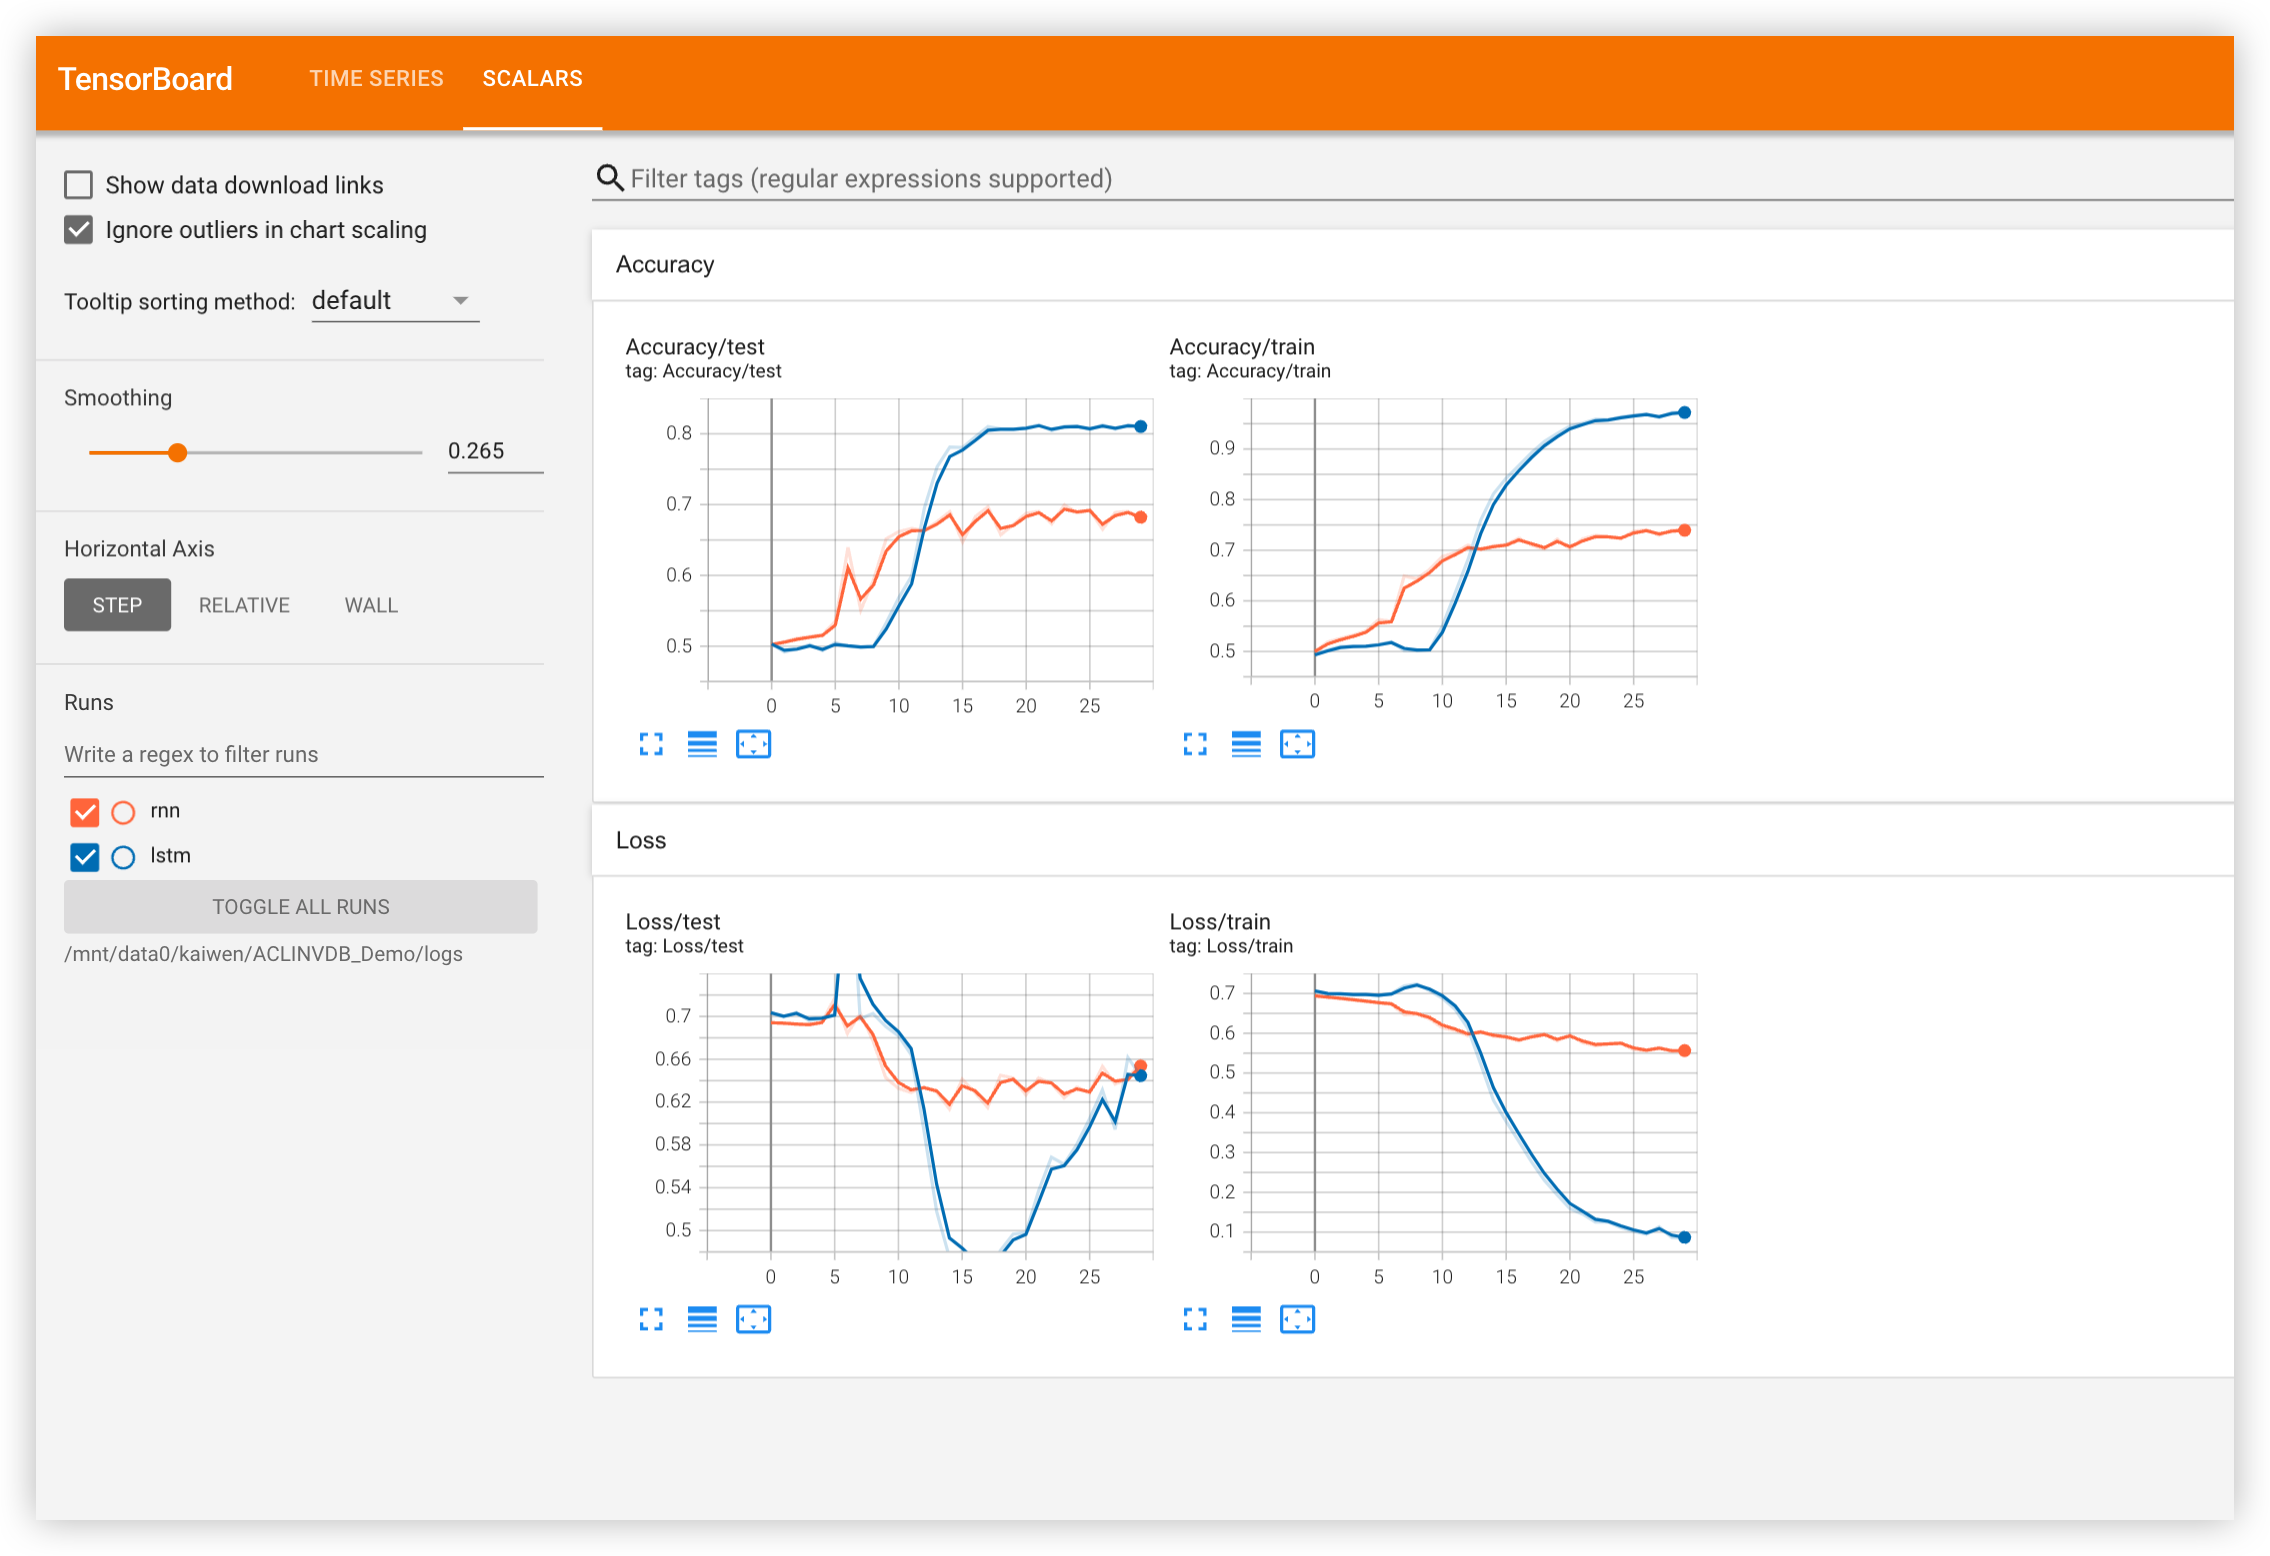

## Test

Before we test the model, we can pass a sample text to the model to see the prediction result.

In [38]:
# use the model to predict
def predict_sentiment(net, vocab, sentence):
    sentence = torch.tensor(
        [vocab.get(word, 1) for word in sentence.split()], device=device
    )
    label = torch.argmax(net(sentence.view((1, -1)), None)[0]).item()
    return "positive" if label == 1 else "negative"


sentence = "the plot was great"

print( predict_sentiment(lstm_net, vocab, sentence))

sentence = "the plot was terrible"

print(predict_sentiment(lstm_net, vocab, sentence))

positive
negative


Now, we need to use the test set to evaluate the model.

In [39]:
import prettytable as pt


def get_evaluation_metrics(net, test):
    """
    Get evaluation metrics:
    1. Accuracy
    2. Precision
    3. Recall
    4. F1 Score
    """
    net.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X, y in test:
            X, y = X.to(device), y.to(device)
            state = None
            output, _ = net(X, state)
            y_true.extend(y.tolist())
            y_pred.extend(output.argmax(dim=1).tolist())

    accuracy = sum([1 for i in range(len(y_true)) if y_true[i] == y_pred[i]]) / len(
        y_true
    )

    TP = sum([1 for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 1])
    FP = sum([1 for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 1])
    FN = sum([1 for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 0])

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * precision * recall / (precision + recall)

    return accuracy, precision, recall, f1_score


lstm_accuracy, lstm_precision, lstm_recall, lstm_f1_score = get_evaluation_metrics(
    lstm_net, test_iter
)

rnn_accuracy, rnn_precision, rnn_recall, rnn_f1_score = get_evaluation_metrics(
    rnn_net, test_iter
)


table = pt.PrettyTable(
    ["Model", "Accuracy", "Precision", "Recall", "F1 Score"],
    float_format=".4",
)

table.add_row(["RNN", rnn_accuracy, rnn_precision, rnn_recall, rnn_f1_score])

table.add_row(["LSTM", lstm_accuracy, lstm_precision, lstm_recall, lstm_f1_score])

table

Model,Accuracy,Precision,Recall,F1 Score
RNN,0.6948,0.7324,0.6138,0.6679
LSTM,0.8247,0.8454,0.7946,0.8193


It can be found that LSTM is better than rnn in metrics such as acc, recall, and f1

## Conclusion

LSTM is easy to train and has better performance than RNN.